# DataScience Bowl 2017- Lung Cancer detection Data
##  Samyakh Tukra

this notebook shows how the data was visualised and different techniques learnt whilst exploring the possible data analysis procedures. Prior to using the CNN I need to first understand what the data shows and how it can be processed.

the data comprises of Lung CT scans of each patient

the following processing is going to take place:
1. Loading the DICOM files, and adding missing metadata
2. Converting the pixel values to Hounsfield Units (HU), and what tissue these  
   unit values correspond to
3. Resampling to an isomorphic resolution to remove variance in scanner 
   resolution.
4. 3D plotting, visualization is very useful to see what we are doing.
   Lung segmentation
5. Normalization
6. Zero centering the scans

inspired by the work of: https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial and other Kaggle Kernel uploaders like Sentdex and etc.

In [16]:
import dicom # CT scans are in DICOM format
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

# specify the folder containig the data files (stage1)
data_directory= r'E:\DataSets\3DCNN_Cancer_detection\stage1'
patients= os.listdir(data_directory) # this simply gets the list of the files names in that directory

# in this case the unique code of that particular patient
# the csv contains the same patient id and the corresponding labels (i.e. 1= cancer, 0= healthy)
patient_id=pd.read_csv(r'E:\DataSets\3DCNN_Cancer_detection\stage1_labels\stage1_labels.csv',index_col=0)

patient_id.head(10) # first 10 patients

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1
0092c13f9e00a3717fdc940641f00015,0
00986bebc45e12038ef0ce3e9962b51a,0
00cba091fa4ad62cc3200a657aeb957e,0
00edff4f51a893d80dae2d42a7f45ad1,1


## Extracting some basic information from the data

In [12]:
# loop through i no of patients (choose a small number just to understand what the data shows)
for i in patients[:2]:
    # get the label (as seen above from the 2nd column 'cancer')
    label= patient_id.get_value(i,'cancer')
    # access the data/slices of each patient folder
    path= os.path.join(data_directory,i)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    # sorting the dicom files via the lambda function:
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    '''DICOM files are made of multiple attributes i.e. patient sex, hospital etc..
    the and ImagePositionPatient is one of those attributes (DICOM-Header) i.e. the slice position
    and we will sort the data based on the no of slices'''
    
    print('\n These are the DICOM attributes of patient: {} \n {}'.format(i,slices[0]))
    print('\n No. of slices: {}, X,Y dimension of the slice: {}, Label: {}'.format(len(slices),slices[0].pixel_array.shape, label))
    

d:\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.



 These are the DICOM attributes of patient: 0015ceb851d7251b8f399e39779d1e7d 
 (0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.321555830121981826540353244716
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0000) Group Length                        UL: 64
(0010, 0010) Patient's Name                      PN: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0020) Patient ID                          LO: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 0000) Group Length                        UL: 390
(0020, 000d) Study Instance UID                  UI: 2.25.51820907428519808061667

So from the above, it can be seen that patients have different number of slices (i.e. depth is different size). plus considering the datasize:


In [13]:
print(label)

0


In [11]:
len(patients)

1595

There are only 1595 data samples. This is not large enough for training a CNN so I can combine other lung cancer datasets like LUNA16 challenge an etc. so I can build more data and that will get the neural net really cooking!
However, in this first pass I do not have enough onboard memory to store all this data (i.e. need a minimum of 100GB storage space). I will be updating this repository with more data and newer models

## Now, Visualising the slices (i.e. data):

d:\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


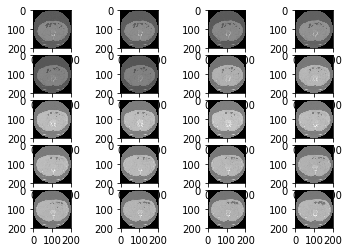

In [20]:
# resizing parameter:
img_size= 125

for i in patients[:1]: #only printing on one for example
    # lets get the label (as seen above from the 2nd column 'cancer')
    label= patient_id.get_value(i,'cancer')
    # access the data/slices of each patient folder
    path= os.path.join(data_directory,i)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    # sorting the dicom files via the lambda function:
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    # resize the image:
    figure=plt.figure() # visualising the first 20 slices:
    for num, each_slice in enumerate(slices[:20]):
        img= figure.add_subplot(5,4, num+1)
        new_img= cv2.resize(np.array(each_slice.pixel_array),(img_size,img_size))
        img.imshow(new_img, cmap='gray')
    plt.show()
    
    '''each of the following is a slice in order (plotted in grayscale) and they
    have been resized to 200 by 200'''
    

In [ ]:
IMG_SIZE_PX = 50
SLICE_COUNT = 20

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

#                                               stage 1 for real.
data_dir = '../input/sample_images/'
patients = os.listdir(data_dir)
labels = pd.read_csv('../input/stage1_labels.csv', index_col=0)

much_data = []
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

the units in CT scan voxels are Hounsfield Units (HU). Air has HU of -1000, water 0 and etc. However, in the pixels above the defualt value returned are not HUs. So let's extract the hounsfield units from the slices.

## Hounsfield Units Extraction:

In [15]:
def HU_pixels(slices):
    img= np.stack([i.pixel_array for i in slices])
    # converting them to data type int16
    img=img.astype(np.int16)
    
    # pixels outside of the scan should be 0, 
    img[img==-2000]=0
    
    #converting to HU:
    for x in range(len(slices)):
        intercept= slices[slice_number].RescaleIntercept
        slope= slices[x].RescaleSlope
        
        if slope !=1:
            image[x]= slope*img[x].astype(np.float64)
            image[x]= img[x].astype(np.int16)
        img[x]+= np.int16(intercept)
        
    return np.array(img, dtype=np.int16)

# let's look at a sample patient:



d:\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


TypeError: 'numpy.int64' object does not support item assignment